In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
import os
# 获取套件的路径
package_path = os.path.join(os.getcwd(), '/Users/chieray/TMBA-ATD-coding/因子研究/python')  # 替换为你套件的实际路径
sys.path.append('/Users/chieray/TMBA-ATD-coding/因子研究/python')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re  # 添加这行
from scipy.cluster import hierarchy as sch
from scipy.spatial.distance import squareform
from scipy import stats
import statsmodels.api as sm
from scipy.optimize import minimize
import alpha_researcher
#from scripts.config import *
#from scripts.factors import *
#from data.scripts.load_data import DataManager
import shioaji as sj

Handler |▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 100% [100/100] in 0.0s (3116915.46/s) 
factor_generator |▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 100% [100/100] in 0.0s (3619909.59/s) 
super_factor_generator |▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 100% [100/100] in 0.0s (4615314.86/s) 
factor_prehandle |▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 100% [100/100] in 0.0s (3534568.87/s) 
factor_merge_valuation |▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 100% [100/100] in 0.0s (5106469.95/s) 
factor_merger |▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 100% [100/100] in 0.0s (5095540.38/s) 
factor_valuation |▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 100% [100/100] in 0.0s (4387697.16/s) 


2025-02-22 11:30:21.169 | WARNING  | importlib._bootstrap:_call_with_frames_removed:241 - Optional: pip install shioaji[speed] for better performance.


# 永豐API

In [ ]:
###公鑰：BW1MFa6o9AjnTB4oBHfxNDqT5YrmWiEYCqTdefCW5Gbe
###私鑰：9DXea8gZwuK27caQLo2iAdE925QPuGR6zL1FLB7PGGuq

In [ ]:
api = sj.Shioaji()
accounts =  api.login("BW1MFa6o9AjnTB4oBHfxNDqT5YrmWiEYCqTdefCW5Gbe", "9DXea8gZwuK27caQLo2iAdE925QPuGR6zL1FLB7PGGuq")
api.activate_ca(
    ca_path="/Users/chieray/Downloads/Sinopac.pfx",
    ca_passwd="Hermes5453",
    person_id="G122356937",
)

In [ ]:
# 商品檔 - 請修改此處
contract = api.Contracts.Stocks.TSE["2890"]

# 證券委託單 - 請修改此處
order = api.Order(
    price=18,                                       # 價格
    quantity=1,                                     # 數量
    action=sj.constant.Action.Buy,                  # 買賣別
    price_type=sj.constant.StockPriceType.LMT,      # 委託價格類別
    order_type=sj.constant.OrderType.ROD,           # 委託條件
    account=api.stock_account                       # 下單帳號
)

# 下單
trade = api.place_order(contract, order)
trade

# 設定交易基本資料

In [47]:
fund=200000000
period='W'
start_date='2015-01-01'
end_date = '2021-01-01'

# 導入資料

In [14]:
Handler=alpha_researcher.Handler(path='/Users/chieray/TMBA-ATD-coding/因子研究/notebook/Handler_cache_max')
factor_generator=alpha_researcher.factor_generator(period=252)
super_factor_generatorr=alpha_researcher.super_factor_generator(period=52)
factor_prehandle=alpha_researcher.factor_prehandle(clip=3)

In [ ]:
####更新nars資料
日資料=pd.read_parquet('/Volumes/Medina_Alpha/PROD_DATA/pmart.parquet')
日資料=日資料.set_index(['datetime','symbol'])
日資料.to_pickle("/Users/chieray/TMBA-ATD-coding/因子研究/data/日資料.pkl")

矩陣資料=日資料.unstack()#.columns.tolist()
矩陣資料.columns = pd.MultiIndex.from_tuples([(lvl0.replace('/', '_'), lvl1) for lvl0, lvl1 in 矩陣資料.columns])

資料列表=矩陣資料.columns.levels[0].unique().tolist()
for 資料名稱 in 資料列表:
    Handler[f'raw:{資料名稱}'] = 矩陣資料[資料名稱]

In [10]:
資料列表 = Handler.cash_list('raw')
模式列表= ['單因子模式','雙因子模式']
底層因子處理列表=['sue_ewm','sue_half','sue_quantile','sue','sue_flow','growth','均線成長','均線交叉','新高因子','no_operating']
因子表達式列表=['no_operating','ts_mean','ts_rank','ts_sharpe','ts_skewness','ts_kurtosis','ts_delay','ts_delta','ts_min','ts_max','ts_argmin','ts_argmax','ts_decay_linear','ts_sum','ts_std','ts_product','scale','cs_rank','cs_normalization','cs_standardization','cs_scale','cs_zscore','cs_quantile','cs_clip','cs_mad','cs_log','cs_minmax_by_column','cs_softmax','signed_power','abs','log','sign']
雙因子處理列表=['add','subtract','multiply','divide','mean','weighted','cov','corr']

# 寫底層因子

In [39]:
單月營收=Handler['raw:單月營收(千元)']
yoy=(單月營收-單月營收.shift(252)).fillna(0)

In [41]:
sue=(yoy-yoy.rolling(252).mean())/(yoy.rolling(252).std())

# 將資料轉為周轉倉

In [23]:
def resample_to_period(df, period):
    df['datetime'] = df.index
    df = df.groupby(df.index.to_period(period)).apply(lambda x: x.iloc[-1])
    df.index = df['datetime']
    df = df.drop(columns=['datetime'])
    return df

In [25]:
調整後開盤價=Handler['raw:開盤價-除權息'].shift(-1)
調整後開盤價_周=resample_to_period(調整後開盤價, period=period)
預期收益率＿周=(調整後開盤價_周.shift(-1)/調整後開盤價_周)-1

In [43]:
sue_周=resample_to_period(sue, period=period)

# 回測

In [44]:
factor_valuation=alpha_researcher.factor_valuation(factor_df=sue_周,return_df=預期收益率＿周,period=52)

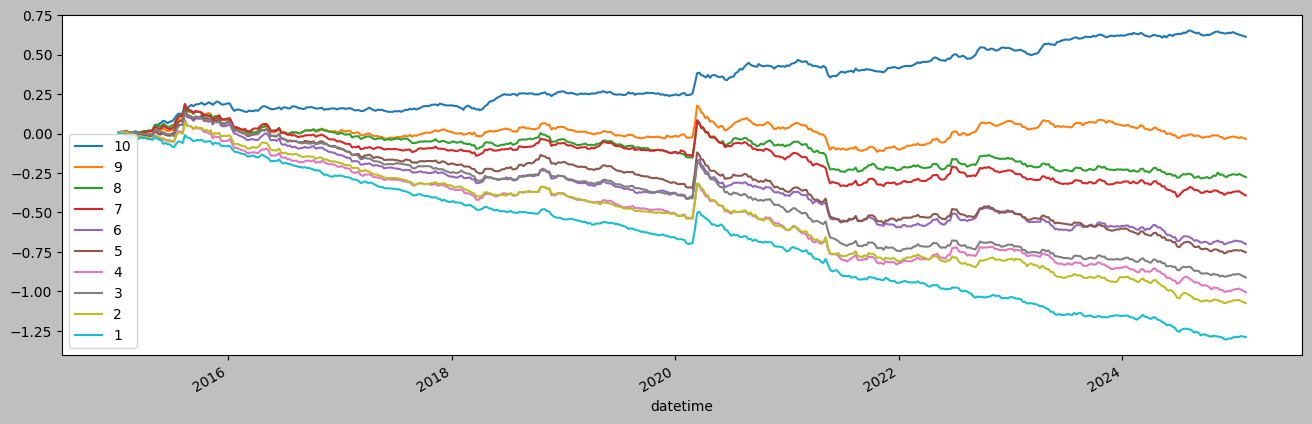

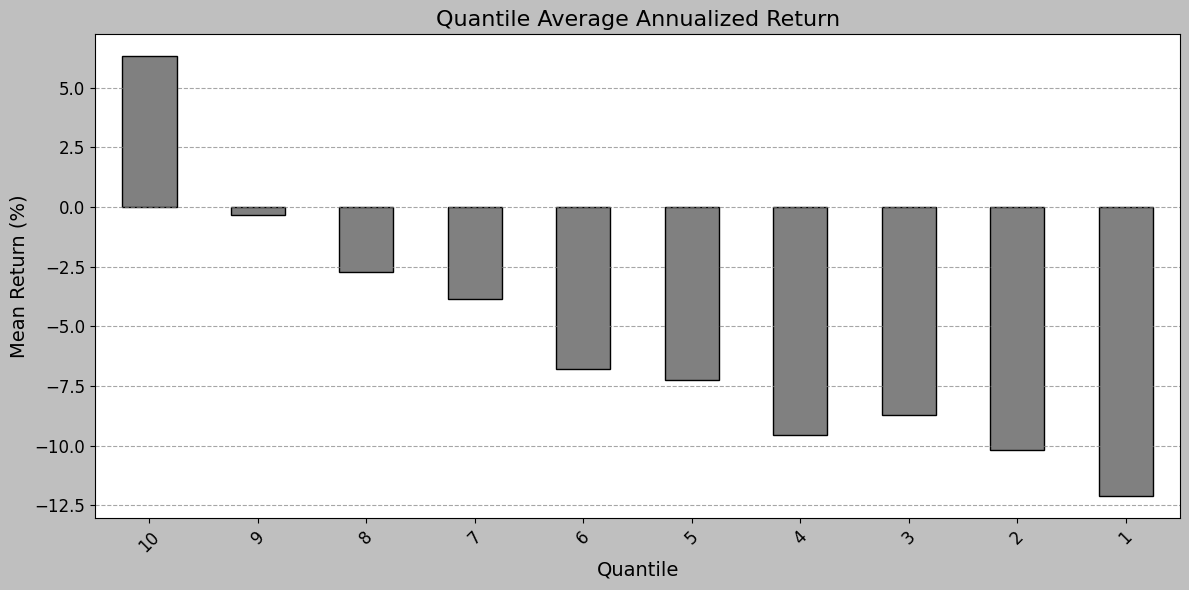

In [48]:
quantile_return=factor_valuation.get_quantile_return_ted(rank_range_n=10)
quantile_return=quantile_return.loc[start_date:]

plt.style.use("grayscale")
fig, ax = plt.subplots(figsize=(16, 5))
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
quantile_return.cumsum().plot(ax=ax, color=color_list)
plt.legend()
plt.show()

factor_valuation.quantile_return_his(quantile_return)

/Users/chieray/TMBA-ATD-coding/因子研究/python/alpha_researcher.py:583: RuntimeWarning: Mean of empty slice
  demeanded = self.factor_df - np.nanmean(self.factor_df,axis=1)[:,None]
/var/folders/x2/75yr957x4dv95sfg2x05yf980000gn/T/ipykernel_7239/2769955532.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


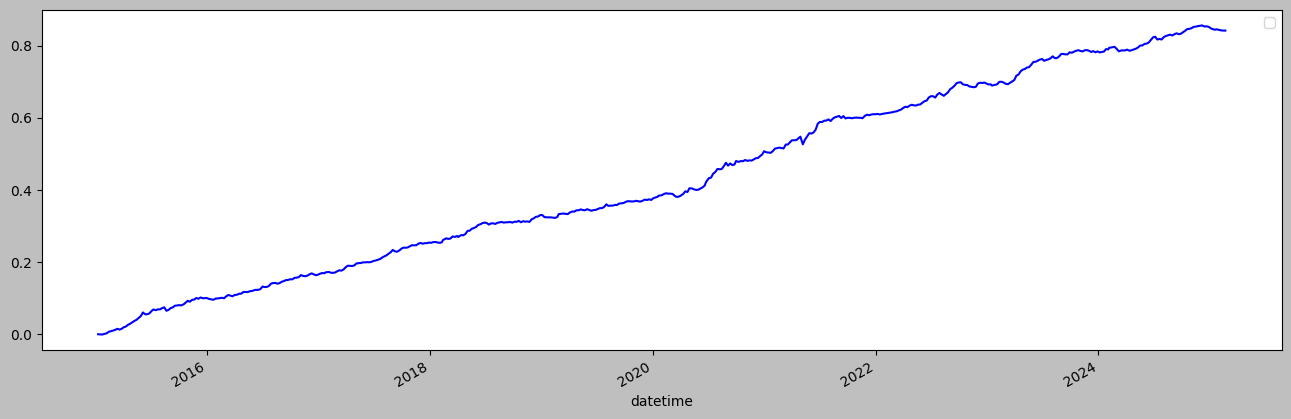

3.363941363183575


In [50]:
demean_ls_w=factor_valuation.factor_to_weight(only_long=False)
demean_ls_se=factor_valuation.get_strategy_return(demean_ls_w, buy_fee=0.04/100, sell_fee=0.04/100,intraday = False)
demean_ls_se=demean_ls_se.loc[start_date:]

plt.style.use("grayscale")
fig, ax = plt.subplots(figsize=(16, 5))
demean_ls_se.cumsum().plot(ax=ax,color='blue')
plt.legend()
plt.show()

print(demean_ls_se.mean()/demean_ls_se.std()*np.sqrt(52))

/var/folders/x2/75yr957x4dv95sfg2x05yf980000gn/T/ipykernel_7239/3254620481.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


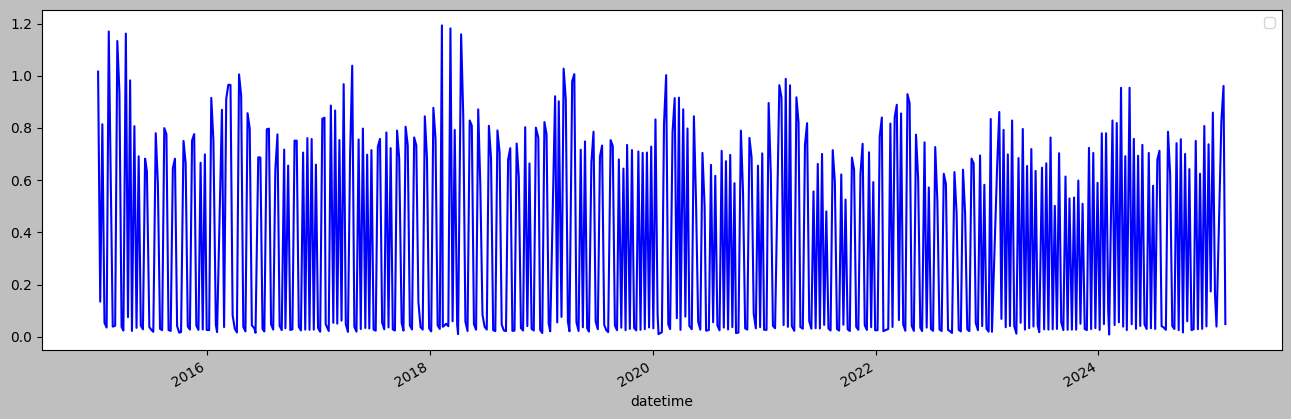

0.3693483438118341


In [51]:
delta_demean_ls_w=demean_ls_w.diff()
daily_trading_value = delta_demean_ls_w.abs().sum(axis=1)
daily_trading_value =daily_trading_value.loc[start_date:]

plt.style.use("grayscale")
fig, ax = plt.subplots(figsize=(16, 5))
daily_trading_value.plot(ax=ax,color='blue')
plt.legend()
plt.show()

print(daily_trading_value.sum() / len(daily_trading_value))

# 機器學習

In [192]:
start_date='2015-01-01'
end_date = '2021-01-01'
# 目标函数优化
def objective(trial):
    ###單因子模式or雙因子模式
    模式選擇 = trial.suggest_categorical("模式選擇", 模式列表)

    資料名稱1 = trial.suggest_categorical("資料名稱1", 資料列表)
    Data_df1 = Handler[資料名稱1]
    #Data_df1 = Data_df1.apply(lambda x: x.fillna(x.mean()), axis=1)
    Data_df1 = Data_df1.apply(lambda x: x.fillna(x.mean()))
    底層因子計算方法1 = trial.suggest_categorical("底層因子計算方法1",底層因子處理列表 )
    底層因子參數1 = trial.suggest_int("底層因子參數1", 1, 105, step=1)
    Data_df1=底層因子處理(Data_df1,底層因子計算方法1,底層因子參數1)
    因子表達式處理次數1 = trial.suggest_int("因子表達式處理次數1",1,10, step=1)
    for i in range (0,因子表達式處理次數1):
        單因子整理方法 = trial.suggest_categorical(f"單因子整理方法{i+1}", 因子表達式列表)
        單因子時序參數 = trial.suggest_int(f"單因子時序參數{i+1}", 1, 105, step=1)
        Data_df1=單因子處理(Data_df1,單因子整理方法, 單因子時序參數)


    if 模式選擇=='雙因子模式':
        ###第二顆因子
        資料名稱2 = trial.suggest_categorical("資料名稱2", 資料列表)
        Data_df2 = Cache_Handler[資料名稱2]
        #Data_df2 = Data_df1.apply(lambda x: x.fillna(x.mean()), axis=1)
        Data_df2 = Data_df2.apply(lambda x: x.fillna(x.mean()))
        底層因子計算方法2 = trial.suggest_categorical("底層因子計算方法2", 底層因子處理列表)
        底層因子參數2 = trial.suggest_int("底層因子參數2", 1, 105, step=1)
        Data_df2=底層因子處理(Data_df2,底層因子計算方法2,底層因子參數2)
        因子表達式處理次數2 = trial.suggest_int("因子表達式處理次數2",1,10, step=1)
        for i in range (0,因子表達式處理次數2):
            雙因子整理方法 = trial.suggest_categorical(f"雙因子整理方法{i+1}", 因子表達式列表)
            雙因子時序參數 = trial.suggest_int(f"雙因子時序參數{i+1}", 1, 105, step=1)
            Data_df2=單因子處理(Data_df2,雙因子整理方法, 雙因子時序參數)
        ###雙因子作用
        雙因子交互方法=trial.suggest_categorical("雙因子交互方法", 雙因子處理列表)
        雙因子交互參數 = trial.suggest_int("雙因子交互參數", 1, 105, step=1)
        Data_df1=雙因子處理(Data_df1,Data_df2,雙因子交互方法,雙因子交互參數)


    ###因子前處理
    Data_df1 =factor_generator.extreme_mad(Data_df1, n=3)
    中性化 = trial.suggest_categorical("中性化", ['好喔','不要'])
    if 中性化 == '好喔':
        中性化因子名稱 = trial.suggest_categorical("中性化因子名稱", 資料列表)
        中性化因子=Cache_Handler[中性化因子名稱]
        try:
            Data_df1=factor_generator.Neutralization(Data_df1 ,中性化因子)
        except KeyError as e :
            Data_df1=Data_df1
    

    Data_df=Data_df1
    ####計算得分
    LS_Se = foctorvaluation.ls_performance_demean(Data_df, exp_monthreturn.loc['2016-01-08':'2021-01-08'], filter=None).loc['2016-01-01':'2021-01-01']
    LS_sharpe = abs((np.sqrt(52) * LS_Se.mean()) / LS_Se.std())
    #IC_Se = get_IC_Se(Data_df, exp_monthreturn).loc['2016-01-08':'2021-01-08']
    IC_Se = get_IC_Se(Data_df, exp_monthreturn)
    IC_Se = IC_Se.sort_index()  # 确保索引是有序的
    IC_Se = IC_Se.loc['2016-01-08':'2021-01-08']

    if IC_Se.std() == 0:
        return -10000
    IC_mean = abs(IC_Se.mean()) #abs(IC_Se.mean())
    ICIR = abs(IC_Se.mean() / IC_Se.std())#abs(IC_Se.mean() / IC_Se.std()) 
    turnover_rate = (factor_to_weight(Data_df, only_long=True)).fillna(0).diff().abs().sum(axis=1).mean()
    Scroe = (LS_sharpe + 10 * ICIR + 100 * IC_mean) * (2 - turnover_rate)
    if LS_sharpe<3:
        #IC_mean=0
        Scroe =Scroe*0.1
    if IC_mean<0.05:
        Scroe =Scroe*0.5
    if ICIR<0.5:
        Scroe =Scroe*0.5
    trial.set_user_attr("IC_mean",IC_mean)
    trial.set_user_attr("ICIR",ICIR)
    trial.set_user_attr("LS_sharpe",LS_sharpe)
    return Scroe

In [194]:
資料列表 = Cache_Handler.cash_list()
end_date = '2021-01-01'
# 目标函数优化
def objective(trial):
    ###單因子模式or雙因子模式
    模式選擇 = trial.suggest_categorical("模式選擇", 模式列表)

    資料名稱1 = trial.suggest_categorical("資料名稱1", 資料列表)
    Data_df1 = Cache_Handler[資料名稱1]
    #Data_df1 = Data_df1.apply(lambda x: x.fillna(x.mean()), axis=1)
    Data_df1 = Data_df1.apply(lambda x: x.fillna(x.mean()))
    底層因子計算方法1 = trial.suggest_categorical("底層因子計算方法1",底層因子處理列表 )
    底層因子參數1 = trial.suggest_int("底層因子參數1", 1, 105, step=1)
    Data_df1=底層因子處理(Data_df1,底層因子計算方法1,底層因子參數1)
    因子表達式處理次數1 = trial.suggest_int("因子表達式處理次數1",1,10, step=1)
    for i in range (0,因子表達式處理次數1):
        單因子整理方法 = trial.suggest_categorical(f"單因子整理方法{i+1}", 因子表達式列表)
        單因子時序參數 = trial.suggest_int(f"單因子時序參數{i+1}", 1, 105, step=1)
        Data_df1=單因子處理(Data_df1,單因子整理方法, 單因子時序參數)


    if 模式選擇=='雙因子模式':
        ###第二顆因子
        資料名稱2 = trial.suggest_categorical("資料名稱2", 資料列表)
        Data_df2 = Cache_Handler[資料名稱2]
        #Data_df2 = Data_df1.apply(lambda x: x.fillna(x.mean()), axis=1)
        Data_df2 = Data_df2.apply(lambda x: x.fillna(x.mean()))
        底層因子計算方法2 = trial.suggest_categorical("底層因子計算方法2", 底層因子處理列表)
        底層因子參數2 = trial.suggest_int("底層因子參數2", 1, 105, step=1)
        Data_df2=底層因子處理(Data_df2,底層因子計算方法2,底層因子參數2)
        因子表達式處理次數2 = trial.suggest_int("因子表達式處理次數2",1,10, step=1)
        for i in range (0,因子表達式處理次數2):
            雙因子整理方法 = trial.suggest_categorical(f"雙因子整理方法{i+1}", 因子表達式列表)
            雙因子時序參數 = trial.suggest_int(f"雙因子時序參數{i+1}", 1, 105, step=1)
            Data_df2=單因子處理(Data_df2,雙因子整理方法, 雙因子時序參數)
        ###雙因子作用
        雙因子交互方法=trial.suggest_categorical("雙因子交互方法", 雙因子處理列表)
        雙因子交互參數 = trial.suggest_int("雙因子交互參數", 1, 105, step=1)
        Data_df1=雙因子處理(Data_df1,Data_df2,雙因子交互方法,雙因子交互參數)


    ###因子前處理
    Data_df1 =factor_generator.extreme_mad(Data_df1, n=3)
    中性化 = trial.suggest_categorical("中性化", ['好喔','不要'])
    if 中性化 == '好喔':
        中性化因子名稱 = trial.suggest_categorical("中性化因子名稱", 資料列表)
        中性化因子=Cache_Handler[中性化因子名稱]
        try:
            Data_df1=factor_generator.Neutralization(Data_df1 ,中性化因子)
        except KeyError as e :
            Data_df1=Data_df1
    

    Data_df=Data_df1
    ####計算得分
    LS_Se = foctorvaluation.ls_performance_demean(Data_df, exp_monthreturn, filter=None).loc['2016-01-01':'2021-01-01']
    LS_sharpe = abs((np.sqrt(52) * LS_Se.mean()) / LS_Se.std())
    IC_Se = get_IC_Se(Data_df, exp_monthreturn).loc['2016-01-01':'2021-01-01']
    if IC_Se.std() == 0:
        return -10000
    IC_mean = abs(IC_Se.mean()) #abs(IC_Se.mean())
    ICIR = abs(IC_Se.mean() / IC_Se.std())#abs(IC_Se.mean() / IC_Se.std()) 
    turnover_rate = (factor_to_weight(Data_df, only_long=True)).fillna(0).diff().abs().sum(axis=1).mean()
    Scroe = (LS_sharpe + 10 * ICIR + 100 * IC_mean) * (2 - turnover_rate)
    if LS_sharpe<3:
        #IC_mean=0
        Scroe =Scroe*0.1
    if IC_mean<0.05:
        Scroe =Scroe*0.5
    if ICIR<0.5:
        Scroe =Scroe*0.5
    trial.set_user_attr("IC_mean",IC_mean)
    trial.set_user_attr("ICIR",ICIR)
    trial.set_user_attr("LS_sharpe",LS_sharpe)
    return Scroe

In [36]:
import optuna

In [ ]:
%%time
# Creating Optuna object and defining its parameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 2000)
trials_dataframe = study.trials_dataframe()
# Showing optimization results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:',study.best_value)

In [38]:
#trials_dataframe.sort_values('value',ascending=False).iloc[950:1000]#.iloc[0]

In [ ]:
df_max_value = (trials_dataframe.dropna(subset=['user_attrs_LS_sharpe']).loc[trials_dataframe.dropna(subset=['user_attrs_LS_sharpe']).groupby('params_資料名稱1')['user_attrs_LS_sharpe'].idxmax()].sort_values('user_attrs_LS_sharpe', ascending=False))

df_max_value.iloc[0:50]

In [19]:
df_max_value=pd.read_pickle("/Users/chieray/TMBA-ATD-coding/因子研究/notebook/選定因子表達式/新年新希望.pkl")

In [20]:
factor_dict = {}

for i in range (0,10):
    best_ = df_max_value.sort_values('value',ascending=False).iloc[i]
    因子一 = get_factor(best_,Cache_Handler)
    new_columns = pd.MultiIndex.from_product([[f'因子_{i}'], 因子一.columns])
    factor_dict[f'因子_{i}'] = pd.DataFrame(因子一.values, index=因子一.index, columns=new_columns)
combined_factors = pd.concat(factor_dict.values(), axis=1) 

/Users/chieray/TMBA-ATD-coding/因子研究/python/factor_generator.py:618: RuntimeWarning: Mean of empty slice
  demeanded = factor_df[column] - np.nanmean(factor_df[column],axis=1)[:,None]
/Users/chieray/TMBA-ATD-coding/因子研究/python/factor_generator.py:618: RuntimeWarning: Mean of empty slice
  demeanded = factor_df[column] - np.nanmean(factor_df[column],axis=1)[:,None]
/Users/chieray/TMBA-ATD-coding/因子研究/python/factor_generator.py:618: RuntimeWarning: Mean of empty slice
  demeanded = factor_df[column] - np.nanmean(factor_df[column],axis=1)[:,None]
/Users/chieray/TMBA-ATD-coding/因子研究/python/factor_generator.py:618: RuntimeWarning: Mean of empty slice
  demeanded = factor_df[column] - np.nanmean(factor_df[column],axis=1)[:,None]
/Users/chieray/TMBA-ATD-coding/因子研究/python/factor_generator.py:618: RuntimeWarning: Mean of empty slice
  demeanded = factor_df[column] - np.nanmean(factor_df[column],axis=1)[:,None]
/Users/chieray/TMBA-ATD-coding/因子研究/python/factor_generator.py:618: RuntimeWarning: M

Negative Values in Analysis Sum:
Series([], dtype: float64)


/Users/chieray/TMBA-ATD-coding/因子研究/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chieray/TMBA-ATD-coding/因子研究/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


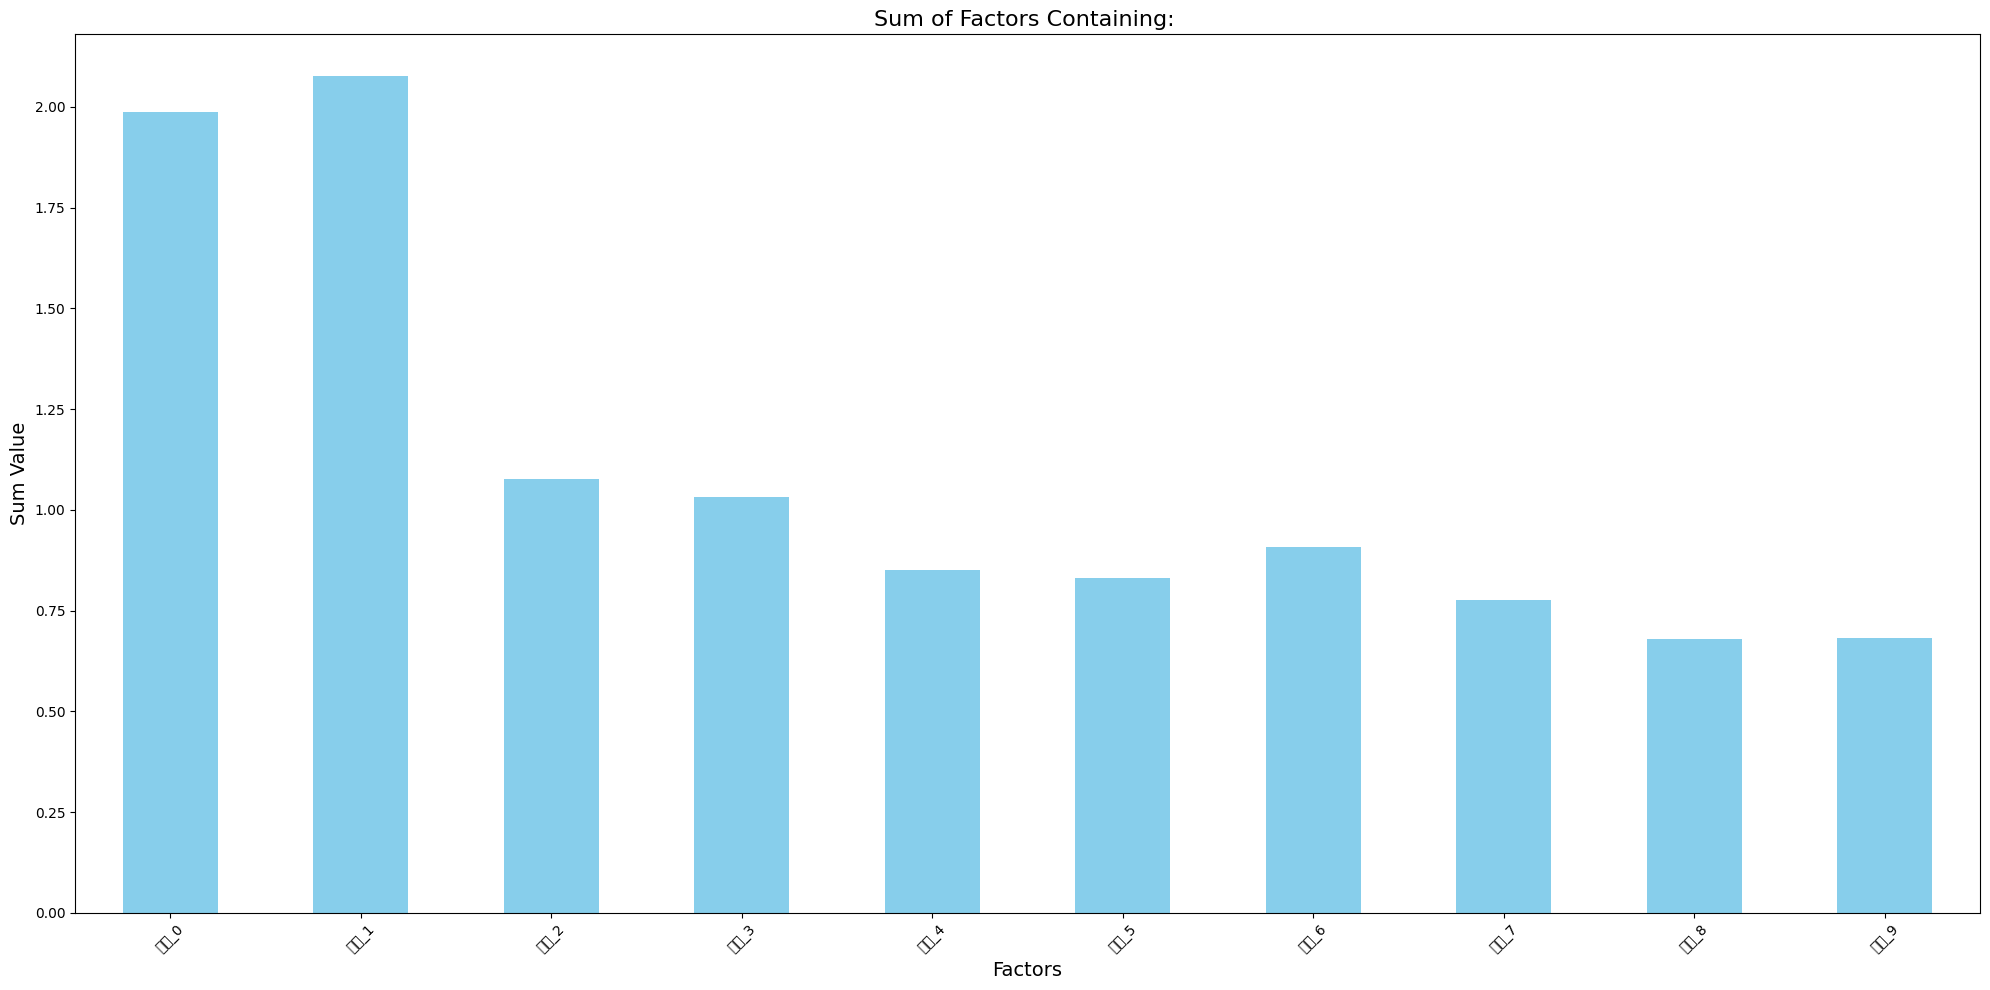

No matching columns found in the first level.


In [21]:
demean_ls_return=factor_generator.calculate_demean_ls_returns(combined_factors, exp_monthreturn, filter_condition=None)
negative_indices = foctorvaluation.analyze_negative_factors(demean_ls_return, '')
factors_to_negate = negative_indices
factor_names = combined_factors.columns.get_level_values(0)
columns_to_negate = [col for col in combined_factors.columns if col[0] in factors_to_negate]
if columns_to_negate:
    combined_factors.loc[:, columns_to_negate] = -1*combined_factors.loc[:, columns_to_negate]
else:
    print("No matching columns found in the first level.")

# 因子合成

In [12]:
def calculate_combine_factor_rolling(df, weights):
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("df必須有MultiIndex列結構")
    result = pd.DataFrame(index=df.index, columns=df.columns.get_level_values(1).unique())
    for column in result.columns:
        symbol = df.xs(column, axis=1, level=1, drop_level=True)
        symbol_bool = symbol.notna()
        if not weights.index.equals(symbol.index):
            weights = weights.reindex(symbol.index)
        if not weights.columns.equals(symbol.columns):
            weights = weights.reindex(columns=symbol.columns)
        symbol_weights = weights.where(symbol_bool)
        symbol_weights = symbol_weights.div(symbol_weights.sum(axis=1), axis=0)
        result_score = symbol.mul(symbol_weights)
        result[column] = result_score.sum(axis=1)
    return result.replace(0, np.nan)

SDK NOTICE Sat Feb 22 13:14:09.768 2025 solClient.c:11120                    (312593000) Session '(c1,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033043/225384/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 192.168.149.18:58956'
SDK NOTICE Sat Feb 22 13:14:09.977 2025 solClient.c:11120                    (312387000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033030/440723/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 192.168.149.18:58945'


Response Code: 0 | Event Code: 12 | Info: Session '(c1,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033043/225384/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 1 | Event: Session reconnecting
Response Code: 0 | Event Code: 12 | Info: Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033030/440723/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 1 | Event: Session reconnecting


SDK NOTICE Sat Feb 22 13:14:12.811 2025 solClient.c:11050                    (312593000) Connect attempt for host '203.66.91.161:80' for session '(c1,s1)_sinopac(client name 'PYAPI/G122356937/0222/033043/225384/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 192.168.149.18:59871')' timed out
SDK NOTICE Sat Feb 22 13:14:13.046 2025 solClient.c:11050                    (312387000) Connect attempt for host '203.66.91.161:80' for session '(c0,s1)_sinopac(client name 'PYAPI/G122356937/0222/033030/440723/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 192.168.149.18:59873')' timed out
SDK NOTICE Sat Feb 22 13:14:15.862 2025 solClientOS.c:4658                   (312593000) TCP connection failure for fd 81, error = Network is unreachable (51)
SDK NOTICE Sat Feb 22 13:14:15.862 2025 solClient.c:5028                     (3125930

Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 3 of 10) | Event: Session reconnected
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 3 of 10) | Event: Session reconnected


SDK NOTICE Sat Feb 22 13:23:23.534 2025 solClient.c:11120                    (312593000) Session '(c1,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033043/225384/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 10.135.245.95:59897'


Response Code: 0 | Event Code: 12 | Info: Session '(c1,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033043/225384/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 1 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sat Feb 22 13:23:23.999 2025 solClient.c:11120                    (312387000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033030/440723/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 10.135.245.95:59900'


Response Code: 0 | Event Code: 12 | Info: Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033030/440723/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 1 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sat Feb 22 13:27:19.081 2025 solClient.c:11120                    (312593000) Session '(c1,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033043/225384/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 10.135.245.95:59942'


Response Code: 0 | Event Code: 12 | Info: Session '(c1,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033043/225384/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 1 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sat Feb 22 13:27:19.574 2025 solClient.c:11120                    (312387000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033030/440723/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 10.135.245.95:59943'


Response Code: 0 | Event Code: 12 | Info: Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/G122356937/0222/033030/440723/101.12.152.48', VPN name 'sinopac', peer host '203.66.91.161:80' address 'IP 203.66.91.161', connection 'tcp_TxRx' local address 'IP 1 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


In [87]:
###因子前處理
combined_factor_mad_neu_std =factor_generator.extreme_mad(combined_factor, n=3)
industry_codes = industry.stack().unique().tolist()
industry_codes = [code for code in industry_codes if isinstance(code, str)]
encoded_industries = {code: (industry == code).astype(int) for code in industry_codes}
industry_dummies = [encoded_industries[ind] for ind in industry_codes]
combined_factor_mad_neu_std =factor_generator.Neutralization(combined_factor_mad_neu_std, *industry_dummies,cap)
combined_factor_mad_neu_std =combined_factor_mad_neu_std.rank(axis=1, pct=True)

/Users/chieray/TMBA-ATD-coding/因子研究/python/factor_generator.py:156: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X = pd.concat({i: X_list[i] for i in range(len(X_list))}, axis=1).stack(dropna=False)


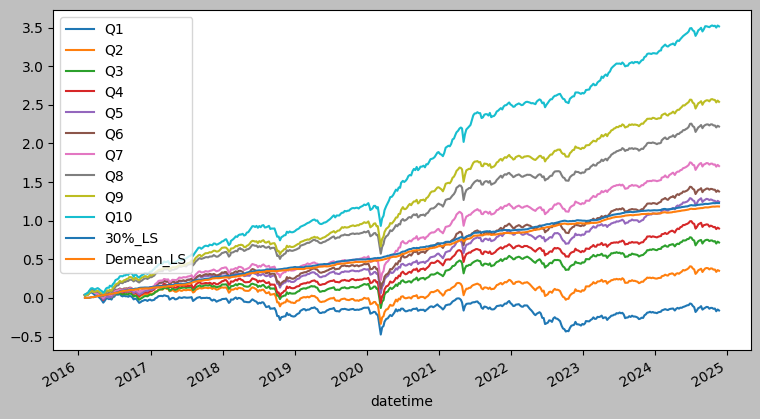

In [90]:
combined_factor_returns=foctorvaluation.combined_factor_returns(combined_factor_mad_neu_std,exp_monthreturn, num_quantiles=10,filter=None)###factor要放filter後因子值
#combined_factor_returns['Q10'].sub(exp_monthreturn[top100_cap].mean(axis=1),axis=0).cumsum().plot()
plt.style.use("grayscale")
fig, ax = plt.subplots(figsize=(9, 5))
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
combined_factor_returns.loc['2016-02-1':'2024-11-26'].cumsum().plot(ax=ax, color=color_list)
plt.legend()
plt.show()

# Barra風險模型

In [97]:
combined_factor_mad_neu_std=pd.read_pickle("/Users/chieray/TMBA-ATD-coding/因子研究/data/mega機器學習因子.pkl")
factor_exposure=pd.read_pickle("/Users/chieray/TMBA-ATD-coding/因子研究/factor_exposure.pkl")
ind_exposure=pd.read_pickle("/Users/chieray/TMBA-ATD-coding/因子研究/ind_exposure.pkl")

In [98]:
###不接受零股交易
close = manager.tool_api_data("收盤價")
close = resample_to_period(close, period=period)

資料集 '收盤價' 包含其他欄位（['Close']），進行 pivot 操作。


In [99]:
fund=20000000
start_date='2016-02-02'
end_date='2025-01-22'

In [101]:
調整係數=manager.tool_api_data("調整係數")
adjopen=industry=manager.tool_api_data("開盤價")['Open']*調整係數['Adjust_Factor']
adjhigh=industry=manager.tool_api_data("最高價")['High']*調整係數['Adjust_Factor']
adjlow=industry=manager.tool_api_data("最低價")['Low']*調整係數['Adjust_Factor']
adjclose=industry=manager.tool_api_data("收盤價")['Close']*調整係數['Adjust_Factor']
adjprice=(adjopen+adjhigh+adjlow+adjclose)/4
adjprice=adjprice.shift(-1)
exp_day_return=(adjprice.shift(-1)/adjprice)-1

###data from MBQ
market=manager.get_data('股價交易資訊',common_stock = False)
market=market[market['證券名稱']=='IX0001']
market['年月'] = pd.to_datetime(market['資料日'], format='%Y/%m/%d')
market.rename(columns= {'年月': 'datetime'}, inplace=True)
market=market.set_index('datetime')
###設置日加權損益
mkprice=(market['開盤價']+market['最高價']+market['最低價']+market['收盤價'])/4
mkprice=mkprice.shift(-1)
market_return=(mkprice.shift(-1)/mkprice)-1

資料集 '調整係數' 包含其他欄位（['Adjust_Factor']），進行 pivot 操作。
資料集 '開盤價' 包含其他欄位（['Open']），進行 pivot 操作。
資料集 '最高價' 包含其他欄位（['High']），進行 pivot 操作。
資料集 '最低價' 包含其他欄位（['Low']），進行 pivot 操作。
資料集 '收盤價' 包含其他欄位（['Close']），進行 pivot 操作。


In [102]:
def get_strategy_day_return(weighting,day_return):
    ###日頻率
    open_indexes = day_return.loc['2015':].index
    weighting =weighting.fillna(0)
    day_weighting = weighting.reindex(open_indexes, method='ffill')
    day_weighting.replace({0: np.nan}, inplace=True)
    delta_weighting = day_weighting.diff()
    day_buy_fee = delta_weighting[delta_weighting > 0].abs() * (0.001425 * 0.3 + 0.003)
    day_buy_fee = day_buy_fee.fillna(0)
    day_sell_fee = delta_weighting[delta_weighting < 0].abs() * (0.001425 * 0.3)  
    day_sell_fee = day_sell_fee.fillna(0) 
    returnseries = ((day_weighting * day_return)-day_buy_fee-day_sell_fee).sum(axis=1) 
    return_df = pd.DataFrame(returnseries, columns=['return']) 
    return return_df

In [ ]:
tse_filter_month=manager.tool_api_data("市場別")['Market']=='TWSE'
tse_filter_month=resample_to_period(tse_filter_month, period=period)
benchmark_weights = cap[tse_filter_month].div(cap[tse_filter_month].sum(axis=1),axis=0).fillna(0)

In [118]:
megaFactor=combined_factor_mad_neu_std.loc[:'2025-01-10']###下次訊號記得拿掉
date_list = megaFactor.loc['2016-1-30':].index
####加權指數非上市為0，可以塞流動性塞選
benchmark_weights = benchmark_weights.loc[date_list] 
last_weights = None
optimal_weights_list = list()
Factor_ = megaFactor.reindex(columns = benchmark_weights.columns)

In [119]:
import cvxpy as cp
def get_optimal_weights(date,Factor,benchmark_weights,filterbooling,ind_exposure:pd.DataFrame,risk_factors:pd.DataFrame,风格因子_dict:dict,last_weights:pd.Series,limitUp: pd.DataFrame = None, limitDown: pd.DataFrame = None,show_exposure:bool = False):
    ###加權指數權重矩陣###額外加濾網矩陣
    benchmark_weights_ = benchmark_weights.loc[date].fillna(0)
    symbol_list=benchmark_weights_.index.tolist()
    #benchmarkBooling_ = (benchmark_weights_>0).astype(float).values
    filterbooling_w=filterbooling.loc[date].fillna(0)
    filterbooling_= (filterbooling_w>0).astype(float).loc[symbol_list].values
    ###我們要打的因子
    Factor_ = Factor.loc[date].loc[symbol_list]
    Factor_ = Factor_.fillna(Factor_.mean())
    # 初始化權重&大盤權重的誤差
    weights = cp.Variable(shape = len(Factor_))
    W_sub_Wb = (weights - benchmark_weights_)
    # 硬約束(當天要打的因子值最大化)
    #objective = cp.Maximize(Factor_.values @ weights) 
    # 軟約束   
    s0 = cp.Variable(1, nonneg=True)  # 鬆弛變數必須非負
    s1 = cp.Variable(1, nonneg=True) 
    #s2 = cp.Variable(1, nonneg=True) 
    #s3 = cp.Variable(1, nonneg=True) 
    s4 = cp.Variable(1, nonneg=True) 
    s5 = cp.Variable(1, nonneg=True) 
    s6 = cp.Variable(1, nonneg=True) 
    s = s4 + s5 + s0 + s6
    objective = cp.Maximize(Factor_.values @ weights - 10*s)
    # 可自定義約束append進去
    constraints = [
                cp.sum(weights) == 1,   # 權重和為 1 
                weights >= 0,           # 權重非負，不允許賣空
                weights @ filterbooling_ >= s0+1,        #if只要成分股0.5調成一
                weights <= 0.2+s1,             # 單支股票權重上限       # 容許可超過一點點原本的要求 ###加filter boolin
                ]
    #constraints.append(cp.abs(weights - benchmark_weights_.values) <= 0.1+s2)         # 個股權重相對基準偏離約束(單支股票權重相對基準偏離上限為 5%)
    #constraints.append(cp.sum(cp.abs(weights - benchmark_weights_.values)) <= 0.5+s3)  # 整體追踪誤差總和小於等於 50%。(最後權重-基準權重=追蹤誤差)
    #risk_factor_= None
    if risk_factors is not None:
        risk_factor_ = risk_factors.loc[date].loc[symbol_list]
        risk_factor_ = risk_factor_.fillna(risk_factor_.mean())
        risk_sigma = risk_factor_.std() * pd.Series(风格因子_dict)
        constraints.append(cp.abs(W_sub_Wb @ risk_factor_.fillna(0).values) <= risk_sigma.values)#+s4)
    # 添加行業暴露限制模型(行業暴露收斂對象為benchmark的基準暴露)#只是因子值改產業名稱
    #ind_exposure= None
    if ind_exposure is not None:
        ind_H = ind_exposure.loc[date].fillna(0).loc[symbol_list]
        constraints.append(cp.abs(W_sub_Wb @ ind_H.values) <= 0/100)#+s5)    # 個股權重相對基準行業偏離約束
    last_weights= None
    # 換手率限制
    if last_weights is not None:
        constraints.append(cp.sum(cp.abs(weights - last_weights.values)) <= 0.3+s6)
        # 漲跌停限制（1與0的矩陣）
        if limitUp is not None and date in limitUp.index:
            label = limitUp.loc[date].values
            # 對於漲停股票，新權重不能高於上期權重
            constraints.append(cp.multiply(weights - last_weights.values, label) <= 0)
        if limitDown is not None and date in limitDown.index:
            label = limitDown.loc[date].values
            # 對於跌停股票，新權重不能低於上期權重
            constraints.append(cp.multiply(weights - last_weights.values, label) >= 0)
    # 處理優化問題
    problem = cp.Problem(objective, constraints)
    test_count = 5
    while True:
        try:
            Exposure = problem.solve(verbose = False)
            break
        except:
            print(f'{date}第{test_count}次尝试')
        test_count+=1
        if test_count>=10:
            print(f'{date}失败！！！')
            Exposure = problem.solve(verbose=True)
    if show_exposure:
        print(f'暴露量:{Exposure}')
    # 優化結果
    optimal_weights = pd.Series(weights.value, index=Factor_.index)
    #print(optimal_weights.loc['2330'])
    return optimal_weights

In [120]:
### 明日开盘价
pure_open = manager.tool_api_data("開盤價")['Open']
pure_open = pure_open.shift(-1)  # 将数据向上移动一行
pure_open_month = resample_to_period(pure_open, period=period)
### 今日收盘价
pure_close = manager.tool_api_data("收盤價")
pure_close_month = resample_to_period(pure_close, period=period) # 转换为月数据
### for barra
up_and_down = pure_open_month / pure_close_month  # 计算开盘价与收盘价的比值
limitDown=(up_and_down < 0.905).astype(int)  # 反转条件判断.loc['2015':'2024-12-1']
limitUp =(up_and_down > 1.095).astype(int)

資料集 '開盤價' 包含其他欄位（['Open']），進行 pivot 操作。
資料集 '收盤價' 包含其他欄位（['Close']），進行 pivot 操作。


In [121]:
风格因子_dict = {'cap':0,
                'lncap':0,
                'nonlinear_size':0,
                'middle_cap':0.25,
                'momentum':0.25,
                'short_term_reversal':0.25,
                'seasonality_factors':0.25,
                'liquidity':0.25,
                'book_to_price':0.25,
                'earning_to_price':0.25,
                'dividend_yield':0.25,
                'betas':0.25,}

风格因子_name_list = list(风格因子_dict.keys())

In [122]:
factorbooling=(cap.rank(axis=1,ascending=False,pct=True)<=100)
factorbooling_value=factorbooling.astype(int)
#limitDown=(up_and_down < 0.905)#.loc['2015':'2024-12-1'].astype(int)  # 反转条件判断
#limitUp =(up_and_down > 1.095)#.loc['2015':'2024-12-1'].astype(int)

import tqdm
#optimal_weights_list=[]
last_weights = None
optimal_weights_list = list()
for date in tqdm.tqdm(date_list):
    optimal_weights = get_optimal_weights(
        date, Factor_, benchmark_weights,factorbooling_value,ind_exposure, factor_exposure, 风格因子_dict, last_weights,limitUp, limitDown
    )
    optimal_weights_list.append(optimal_weights)
    last_weights = optimal_weights  # 權重更新

optimal_weight_df = pd.concat(optimal_weights_list, axis=1, keys=date_list).T
optimal_weight_df = optimal_weight_df.round(4)
optimal_weight_df = optimal_weight_df[optimal_weight_df > 0]
optimal_weight_df = optimal_weight_df.div(optimal_weight_df.sum(axis=1), axis=0)
#optimal_weight_df.loc['2024-11-29'].dropna()#####檢查最後一次訊號

 21%|██        | 98/463 [00:41<02:24,  2.52it/s]/Users/chieray/TMBA-ATD-coding/因子研究/.conda/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 96%|█████████▌| 443/463 [03:02<00:08,  2.27it/s]/Users/chieray/TMBA-ATD-coding/因子研究/.conda/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 463/463 [03:11<00:00,  2.42it/s]


In [144]:
combined_df = pd.concat([strategy_return_day.shift(2),market_return.shift(2)], axis=1, join='inner')
combined_df['IX0001']=combined_df[0]
del combined_df[0]
# 查看结果
combined_df['IX0001_alpha']=combined_df['return']-combined_df['IX0001']

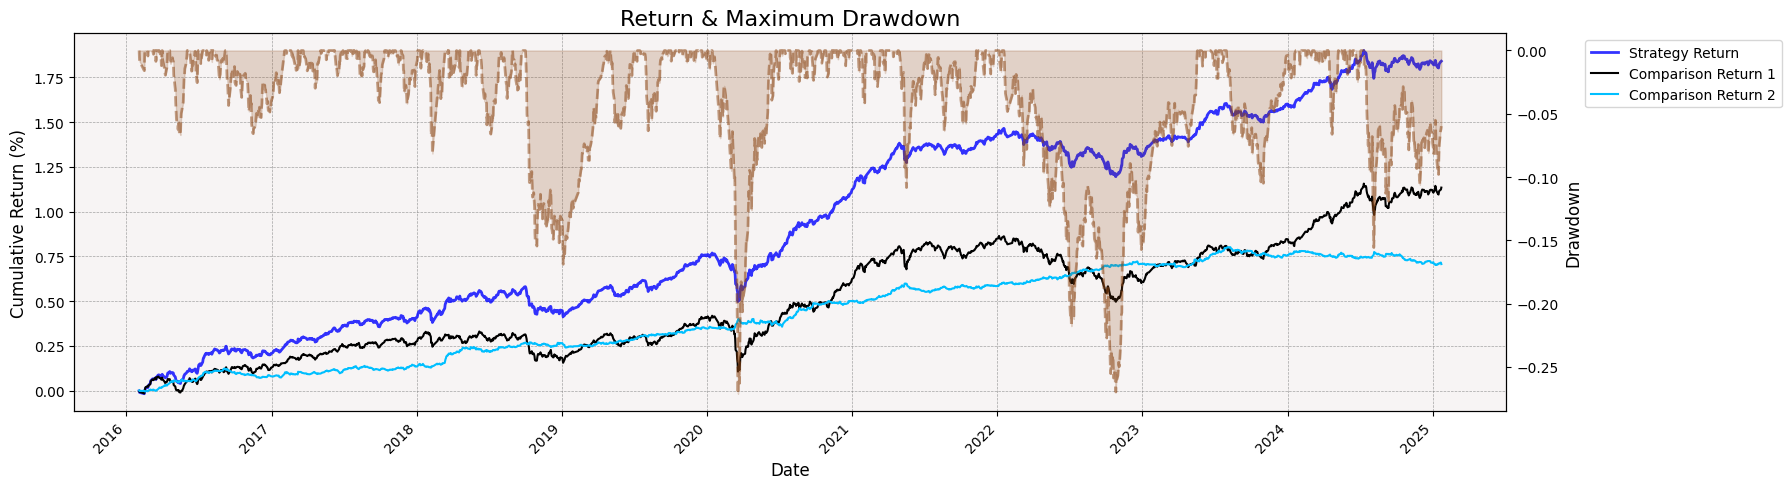

In [145]:
foctorvaluation.plot_compare_return(combined_df['return'].loc[start_date:end_date], combined_df['IX0001'].loc[start_date:end_date],combined_df['IX0001_alpha'].loc[start_date:end_date])

In [146]:
combined_df.loc[start_date:end_date].apply(foctorvaluation.calculate_metrics_day)

/Users/chieray/TMBA-ATD-coding/因子研究/python/foctorvaluation.py:447: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_win_rate = round(returns.resample('M').apply(lambda x: 1 + x.sum() > 1).mean() * 100, 2)
/Users/chieray/TMBA-ATD-coding/因子研究/python/foctorvaluation.py:448: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_win_rate = round(returns.resample('Y').apply(lambda x: 1 + x.sum() > 1).mean() * 100, 2)


,return,IX0001,IX0001_alpha
年化收益率(%),23.60,13.95,8.47
年化标准差(%),13.18,12.97,4.86
年化夏普比率,1.61,1.01,1.67
诺丁比率,2.03,1.23,2.87
卡玛比率,0.87,0.38,0.85
在市场上时间(%),100.00,100.00,100.00
MDD(%),-27.12,-36.78,-9.98
最长回撤日数,320.00,507.00,355.00
Profit Factor,1.32,1.19,1.33
日胜率(%),58.18,56.99,53.24


In [126]:
yearly_metrics = pd.DataFrame()
for year in range(2016,2025):  
    yearly_data = combined_df['IX0001_alpha'].loc[start_date:end_date].loc[str(year)]
    metrics = foctorvaluation.calculate_metrics_day(yearly_data)
    yearly_metrics[year] = metrics
yearly_metrics

/Users/chieray/TMBA-ATD-coding/因子研究/python/foctorvaluation.py:447: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_win_rate = round(returns.resample('M').apply(lambda x: 1 + x.sum() > 1).mean() * 100, 2)
/Users/chieray/TMBA-ATD-coding/因子研究/python/foctorvaluation.py:448: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_win_rate = round(returns.resample('Y').apply(lambda x: 1 + x.sum() > 1).mean() * 100, 2)
/Users/chieray/TMBA-ATD-coding/因子研究/python/foctorvaluation.py:447: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_win_rate = round(returns.resample('M').apply(lambda x: 1 + x.sum() > 1).mean() * 100, 2)
/Users/chieray/TMBA-ATD-coding/因子研究/python/foctorvaluation.py:448: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_win_rate = round(returns.resamp

,2016,2017,2018,2019,2020,2021,2022,2023,2024
年化收益率(%),10.51,5.81,14.14,8.97,16.98,9.14,13.54,4.98,-3.69
年化标准差(%),6.04,4.56,5.33,3.68,6.26,4.64,4.35,5.15,5.08
年化夏普比率,1.65,1.24,2.48,2.33,2.51,1.88,2.92,0.94,-0.74
诺丁比率,2.13,2.37,4.80,3.76,4.12,3.75,5.54,1.42,-1.32
卡玛比率,1.68,2.19,5.12,3.60,3.92,1.81,8.29,0.84,-0.51
在市场上时间(%),100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
MDD(%),-6.27,-2.65,-2.76,-2.49,-4.33,-5.04,-1.63,-5.91,-7.18
最长回撤日数,80.00,81.00,57.00,54.00,83.00,161.00,25.00,98.00,208.00
Profit Factor,1.36,1.26,1.52,1.46,1.52,1.37,1.59,1.18,0.88
日胜率(%),56.56,53.25,50.61,54.96,55.51,52.87,54.47,54.81,46.09


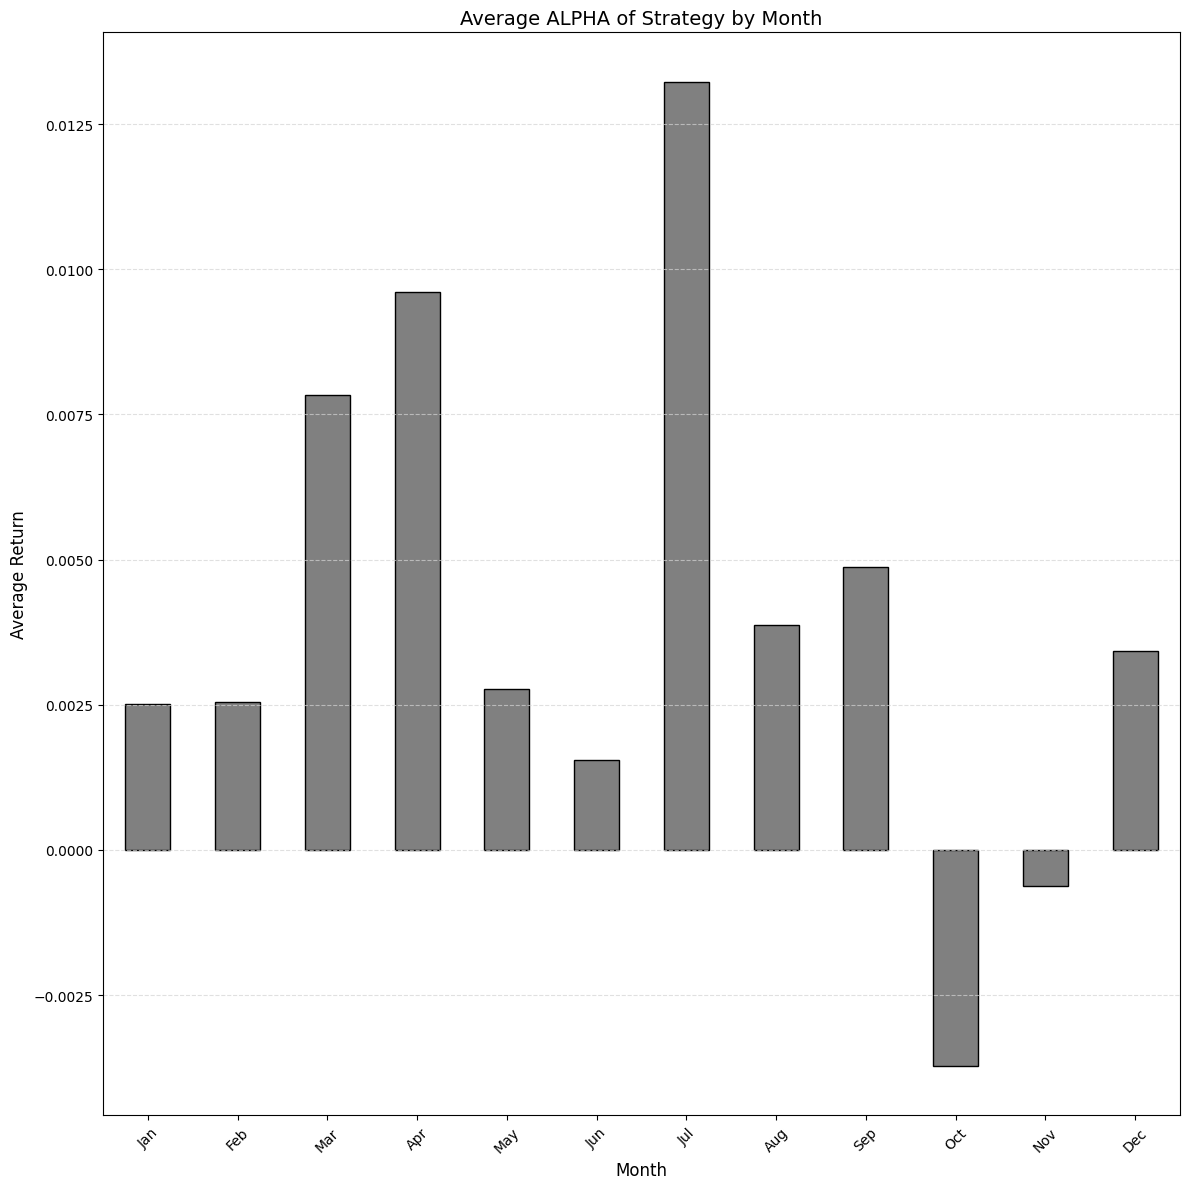

In [127]:
if not isinstance(combined_df.index, pd.DatetimeIndex):
    combined_df.index = pd.to_datetime(combined_df.index)
alpha = combined_df['IX0001_alpha'].loc[start_date:end_date]
if not isinstance(alpha.index, pd.DatetimeIndex):
    alpha.index = pd.to_datetime(alpha.index)
alpha = alpha.to_frame(name='return')
alpha['Month'] = alpha.index.month
monthly_mean_return = alpha.groupby('Month')['return'].mean() * 12
plt.figure(figsize=(12, 12))
monthly_mean_return.plot(kind='bar',legend=False,color='gray',edgecolor='black')
plt.title('Average ALPHA of Strategy by Month', fontsize=14, color='black')
plt.xlabel('Month', fontsize=12, color='black')
plt.ylabel('Average Return', fontsize=12, color='black')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45, fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')
plt.grid(axis='y', linestyle='--', alpha=0.7, color='lightgray')
plt.tight_layout()
plt.show()
del alpha['Month']

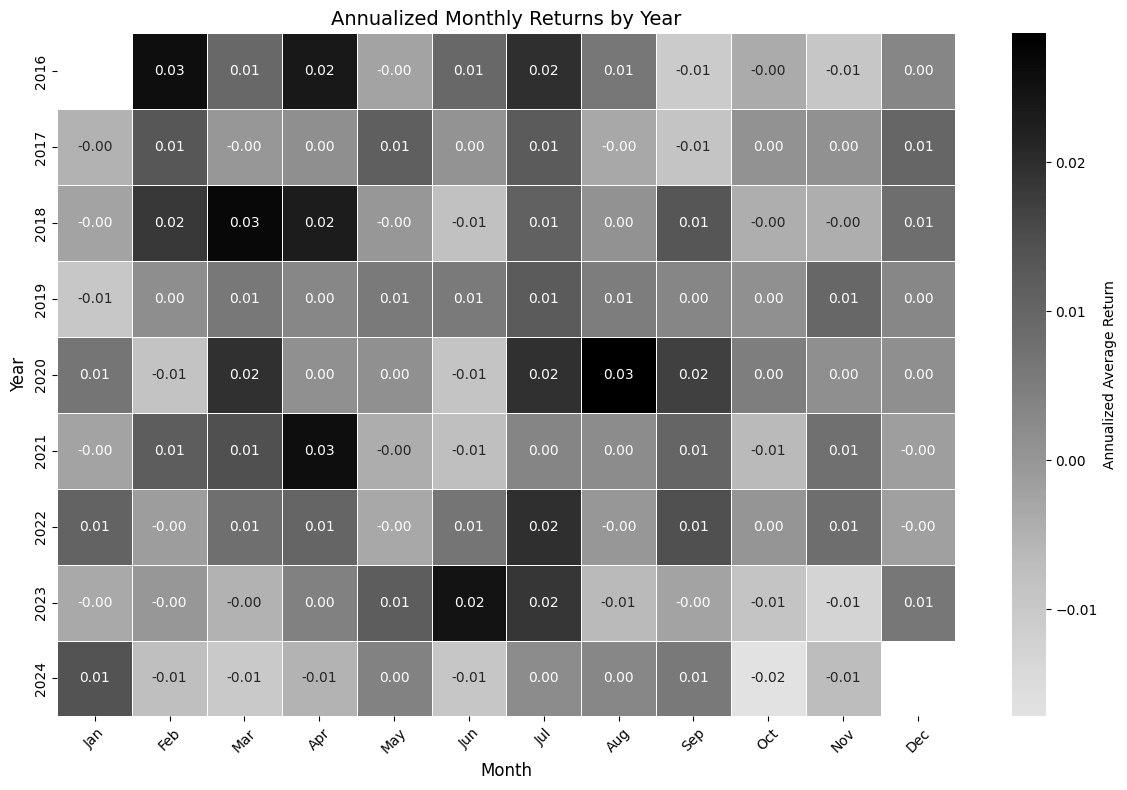

In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
alpha['Year'] = alpha.index.year
alpha['Month'] = alpha.index.month
heatmap_data = alpha.loc['2016-02-26':'2024-11-29'].pivot_table(values='return',index='Year',columns='Month',aggfunc=lambda x: x.mean() * 12 )
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_data.columns = pd.Index(months[:heatmap_data.shape[1]])
plt.figure(figsize=(12, 8))
custom_cmap = sns.color_palette("Greys", as_cmap=True)
sns.heatmap(heatmap_data, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, center=0, cbar_kws={'label': 'Annualized Average Return'})
plt.title('Annualized Monthly Returns by Year', fontsize=14, color='black')
plt.xlabel('Month', fontsize=12, color='black')
plt.ylabel('Year', fontsize=12, color='black')
plt.xticks(fontsize=10, color='black', rotation=45)
plt.yticks(fontsize=10, color='black')
plt.tight_layout()
plt.show()
alpha.drop(columns=['Month', 'Year'], inplace=True)

In [129]:
weighting_m2.to_pickle("/Users/chieray/TMBA-ATD-coding/因子研究/data/機器學習因子訊號.pkl")

# 訊號產生器

In [130]:
weighting=pd.read_pickle("/Users/chieray/TMBA-ATD-coding/因子研究/data/機器學習因子訊號.pkl")

In [131]:
date='2025-01-17'

In [132]:
weighting.replace({0: np.nan}, inplace=True)
weighting_transpose = weighting.T
close_transpose = close.T
#name = 
#name_transpose = name.T
industry=manager.tool_api_data("主產業別_英文")['Industry_Eng']
industry=resample_to_period(industry, period=period)
industry_transpose = industry.T
need_fund = fund*weighting 
need_fund_transpose = need_fund .T
target_amount = need_fund/close
target_amount_transpose = target_amount .T    
last_column_weighting = weighting_transpose.loc[:,date]
last_column_close = close_transpose.loc[:, date]
#last_column_name = name_transpose.loc[:, date]
last_column_industry = industry_transpose.loc[:, date]
last_column_need_fund  = need_fund_transpose.loc[:, date]
last_column_target_amount  = target_amount_transpose.loc[:, date]
weighting_df = pd.DataFrame({'stock': last_column_weighting.index, 'weight': last_column_weighting.values})
close_df = pd.DataFrame({'stock': last_column_close.index, 'close': last_column_close.values})
#name_df = pd.DataFrame({'stock': last_column_name.index, 'name': last_column_name.values})
industry_df = pd.DataFrame({'stock': last_column_industry.index, 'industry': last_column_industry.values})
need_fund_df = pd.DataFrame({'stock': last_column_need_fund.index, 'need_fund': last_column_need_fund.values})
target_amount_df = pd.DataFrame({'stock': last_column_target_amount.index, 'target_amount': last_column_target_amount.values})
#result_df = pd.merge( name_df, industry_df, on='stock')
result_df = pd.merge(industry_df,close_df, on='stock')
result_df = pd.merge(result_df,weighting_df, on='stock')
result_df = pd.merge(result_df,need_fund_df, on='stock')
result_df = pd.merge(result_df,target_amount_df, on='stock')
result_df = result_df.dropna(axis=0)

資料集 '主產業別_英文' 包含其他欄位（['Industry_Eng']），進行 pivot 操作。


In [133]:
(need_fund.iloc[-1].T.dropna()).iloc[0:50]

Series([], Name: 2025-01-22 00:00:00, dtype: float64)